<a href="https://colab.research.google.com/github/hida0/ESAA-2022-2/blob/HW/Week04_HW2_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 교재 필사
핸즈온 7장 앙상블 학습과 랜덤 포레스트 p. 245-271

### 1. 투표 기반 분류기(VotingClassifier)
- 정확도가 80%인 로지스틱 회귀 분류기, SVM 분류기, 랜덤 포레스트 분류기, K-최근접 이웃 분류기 등이 있다. 
- 더 좋은 분류기를 만드는 방법으로 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것이다. 이렇게 **다수결 투표**로 정해지는 분류기를 **직접 투표 분류기**라고 한다.
- 각 분류기가 랜덤 추측보다 조금 더 높은 성능을 내는 분류기인 약한 학습기일지라도, 충분하게 많고 다양하다면 **앙상블은 높은 정확도를 나타내는 강한 학습기**가 될 수 있다.
---
- 다음은 여러 분류기를 조합하여 **사이킷런의 투표 기반 분류기(VotingClassifier)**를 만들고 훈련시키는 코드이다.
- 훈련 세트는 moons 데이터셋을 이용한다.
- 개별 분류기와 앙상블 분류기의 테스트셋 정확도를 확인한다.
- 투표 기반의 앙상블 분류기가 다른 개별 분류기보다 성능이 조금 더 높다.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], 
    voting = 'hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [ ]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.912
SVC 0.896
VotingClassifier 0.904


### 1. 투표 기반 분류기(VotingClassifier)
- 모든 분류기가 클래스의 확률을 예측하는 **`predict_proba( )`** 메서드가 있으면 개별 분류기의 **예측을 평균 내어 확률이 가장 높은 클래스를 예측**할 수 있다. 이를 **간접 투표**라고 한다.
- 이 방식은 확률이 높은 투표에 더 비중을 두기 때문에 **직접 투표 방식보다 성능이 높다**.
- 모든 분류기가 클래스의 확률을 추정할 수 있다면, 분류기의 하이퍼 파라미터를 **`voting='soft'`**를 바꾸는 방식으로 사용한다.
- SVC는 기본값에서는 클래스 확률을 제공하지 않으므로 probability 매개변수를 True로 지정해야 한다.

### 2. 배깅과 페이스팅
- 다양한 분류기를 만드는 또 다른 방법은 **같은 알고리즘을 사용**하고, **훈련 세트의 서브셋을 무작위로 구성**하여 **분류기를 각기 다르게 학습**시키는 것이다.
- 훈련 세트에서 **중복을 허용하여 샘플**링하는 방식을 **배깅**(bagging, bootstrap aggregating의 줄임말)이라 하고, **중복을 허용하지 않고 샘플링**하는 방식을 **페이스팅**(pasting)라고 한다.
- 배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용할 수 있다. 
- 배깅만이 중복을 허용하므로 하나의 예측기를 위해 같은 훈련 샘플을 여러번 샘플링할 수 있다.
---
- 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다. 
- 전형적으로 수집 함수는 **분류**일 때는 가장 많은 예측 결과, 즉 **통계적 최빈값**이고, **회귀**일 때는 **평균**을 계산한다.
- **개별 예측기**는 원본 훈련 세트로 훈련시킨 것보다 훨씬 **크게 편향**되어 있지만, **수집 함수를 통과하면 편향과 분산이 모두 감소**한다.
- 일반적으로 **앙상블의 결과**는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교하여 **편향은 비슷하지만 분산은 감소**한다.

### 2. 배깅과 페이스팅
### 1) 사이킷런의 배깅과 페이스팅
- 사이킷런은 배깅과 페이스팅을 위해 **`BaggingClassifier`**, 회귀일 경우 **` BaggingRegressor`**를 제공한다.
- 다음은 결정 트리 분류기 500개의 앙상블을 훈련시키는 코드이다. 
- 각 분류기는 훈련 세트에서 **중복을 허용하여 무작위로 선택**된 100개의 샘플로 훈련된다. 이는 배깅의 경우이고, 대신 페이스팅을 사용하려면 **`bootstrap=False`**로 지정한다.
- **`n_jobs`**는 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정하며, -1로 지정하면 가용한 모든 코어를 사용한다.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

### 2. 배깅과 페이스팅
### 1) 사이킷런의 배깅과 페이스팅
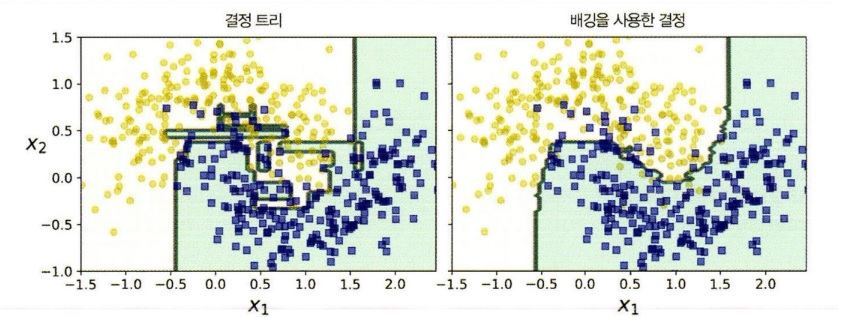
- 다음 그림은 단일 결정 트리 결정 경계와 500개의 트리를 사용한 배깅 앙상블의 결정 경계를 비교한 것이다.
- 그림에서 볼 수 있듯이 앙상블의 예측이 결정 트리 하나의 예측보다 훨씬 일반화가 잘된 것 같다.
- **앙상블**은 **비슷한 편향에서 더 작은 분산**을 만든다. 즉 훈련 세트의 오차 수가 거의 비슷하지만, **결정 경계가 덜 불규칙**하다.
---
- 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로, **배깅이 페이스팅보다 편향이 조금 더 높다**. 하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 **분산을 감소**시킨다.
- 전반적으로 **배깅이 더 나은 모델**을 만들기 때문에, 일반적으로 **페이스팅보다 배깅을 더 선호**한다.

### 2. 배깅과 페이스팅
### 2) oob 평가
- 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러번 샘플링되고, 어떤 것은 전혀 선택되지 않을 수 있다. 
- **`BaggingClassifier`**는 기본값으로 중복을 허용하여 훈련 세트의 크기만큼인 m개 샘플을 선택한다. 이는 평균적으로 **각 예측기에 훈련 샘플의 63%만 샘플링된다**는 것을 의미한다.
- **선택되지 않은 훈련 샘플의 나머지 37%**를 **oob 샘플**(out-of-bag)이라고 한다. 예측기마다 남겨진 37%는 모두 다르다.
---
- 예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 **별도의 검증 세트를 사용하지 않고, oob 샘플을 사용해 평가**할 수 있다.
- 앙상블의 평가는 **각 예측기의 oob 평가를 평균**하여 얻는다.
- 사이킷런에서 `BaggingClassifier`를 만들때 **`oob_score=True`**로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행한다.
- 평가 점수 결과는 모델의 **oob_score_**에 저장된다.
- oob 평가 결과를 보면 이 앙상블 분류기는 테스트 세트에서 약 90.4%의 정확도를 얻을 것이다. 실제로 예측을 수행한 결과 91.2%의 비슷한 정확도를 얻었다.
---
- oob 샘플에 대한 결정 함수의 값도 **oob_decision_function_**에서 확인할 수 있다. 
- 이 경우에는 기반이 되는 예측기가 predict_proba( ) 메서드를 가지고 있기 때문에, 결정 함수는 각 훈련 샘플의 클래스 확률을 반환한다.

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.904

In [ ]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

### 3. 랜덤 패치와 랜덤 서브스페이스
- `BaggingClassifier`는 **특성 샘플링**도 지원한다. 
- 샘플링은 **max_features**, **bootstrap_features** 두 매개변수로 조절된다.
- 작동 방식은 max_samples, bootstrap과 동일하지만, 샘플이 아닌 특성에 대한 샘플링이다.
- 따라서 **각 예측기는 무작위로 선택된 입력 특성의 일부분으로 훈련**된다. 이 기법은 매우 고차원의 데이터셋을 다룰 때 유용하다.
- **훈련 특성과 샘플을 모두 샘플링**하는 것을 **랜덤 패치 방식**이라고 한다.
- **훈련 샘플은 모두 사용**하고(`bootstrap=False, max_samples=1.0`), **특성은 샘플링**하는(`bootstrap_features=True, max_features<1.0`) 것을 **랜덤 서브스페이스 방식**이라고 한다.
- 특성 샘플링은 더 다양한 예측기를 만들며, **편향을 늘리는 대신 분산을 낮춘다**.

### 4. 랜덤 포레스트
- **랜덤 포레스트**는 일반적으로 **배깅 방법을 적용한 결정 트리의 앙상블**이다. 
- 전형적으로 max_samples를 훈련 세트의 크기로 지정한다.
- `BaggingClassifier`에 `DecisionTreeClassifier`를 넣어 만드는 대신, **결정 트리에 최적화**되어 사용하기 편리한 **`RandomForestClassifier`를 사용**할 수 있다.
- 다음은 최대 16개의 리프 노드를 갖는 500개 트리로 이뤄진 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련시키는 코드이다.
---
- `RandomForestClassifier`는 몇가지 예외가 있지만 `DecisionTreeClassifier`의 매개변수와 앙상블 자체를 제어하는데 필요한 `BaggingClassifier`의 매개변수를 모두 가지고 있다.
- **랜덤 포레스트 알고리즘**은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신, **무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식**으로 무작위성을 더 주입한다.
- 이는 결국 트리를 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만든다.
- BaggingClassifier에 다음과 같이 지정하면 앞의 RandomForestClassifier과 거의 유사하게 만들 수 있다. **`BaggingClassifier(DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16), n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)`**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

### 4. 랜덤 포레스트
### 1) 엑스트라 트리
- 랜덤 포레스트에서 트리를 만들때 각 노드는 **무작위로 특성의 서브셋을 만들어 분할에 사용**한다.
- 트리를 **더욱 무작위**하게 만들기 위해 최적의 임계값을 찾는 대신, **후보 특성을 사용하여 무작위로 분할한 다음 그 중에서 최상의 분할을 선택**한다.
- 이와 같이 극단적으로 무작위한 트리의 랜덤 포레스트를 **익스트림 랜덤 트리 앙상블(또는 엑스트라 트리)**라고 한다.
- 엑스트라 트리에서도 역시 편향이 늘어나지만 분산이 줄어든다.
- 모든 노드에서 특성마다 가장 최적의 임계값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로, **일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠르다**.
- 엑스트라 트리를 만들려면 사이킷런의 **`ExtraTreesClassifier`**를 사용하며, 사용법은 `RandomForestClassifier`와 같다.

### 4. 랜덤 포레스트
### 2) 특성 중요도
- 랜덤 포레스트의 또 다른 장점은 **특성의 상대적 중요도를 측정하기 쉽다**는 것이다.
- 사이킷런은 어떤 특성을 사용한 노드가 랜덤 포레스트의 모든 트리에 걸쳐서 평균적으로 **불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정**한다. 
- 더 정확히 말하면 가중치 평균이며, 각 노드의 가중치는 연관된 훈련 샘플 수와 같다.
- 사이킷런은 훈련이 끝난 뒤 특성마다 **자동으로 이 점수를 계산**하고, **중요도의 전체 합이 1**이 되도록 결과값을 정규화한다.
- 특성 중요도 값은 모델의 **feature_importances_**에 저장된다.
- **랜덤 포레스트**는 특히 **특성을 선택**해야 할 때,** 어떤 특성이 중요한지 빠르게 확인**할 수 있어 매우 편리하다.
---
- 다음 코드는 iris 데이터셋에 RandomForestClassifier를 훈련시키고 각 특성의 중요도를 출력한다.
- 가장 중요한 특성은 꽃잎의 길이(45%)와 너비(45%)이고, 꽃받침의 길이(8%)와 너비(2%)는 비교적 덜 중요해보인다.

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10404552811333745
sepal width (cm) 0.024007707243440184
petal length (cm) 0.42653265595192846
petal width (cm) 0.4454141086912939


### 5. 부스팅
- **부스팅**은 **약한 학습기를 여러개 연결하여 강한 학습기를 만드는 앙상블** 방법이다.
- 부스팅 방법의 아이디어는 **앞의 모델을 보완해나가면서 일련의 예측기를 학습**시키는 것이다. 
- 부스팅 방법에는 여러 가지가 있지만 가장 인기 있는 것은 **에이다부스트**(AdaBoost)와 **그레이디언트 부스팅**(gradient boosting)이다.

### 5. 부스팅
### 1) 에이다부스트
- 이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 **이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것**이다. 
- 이렇게 하면 **새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 되는데**, 이것이 에이다부스트에서 사용하는 방식이다.
---
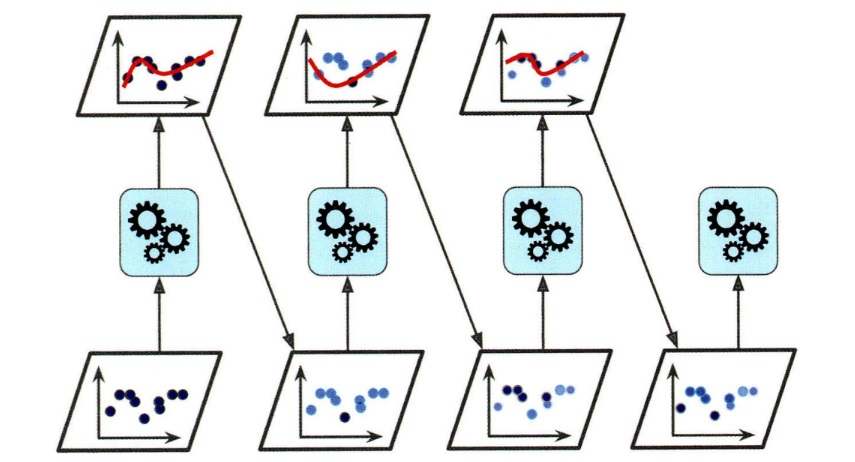
- 다음 그림은 에이다부스트의 학습 과정을 나타낸 그림이다.
- 예를 들어 에이다부스트 분류기를 만들 때 먼저 알고리즘이 기반이 되는 첫번째 분류기를 훈련 세트에서 훈련시키고 예측을 만든다. 그 다음에 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높인다. 
- 두번째 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만든다. 그 다음에 다시 가중치를 업데이트하는 식으로 계속된다.


### 5. 부스팅
### 1) 에이다부스트
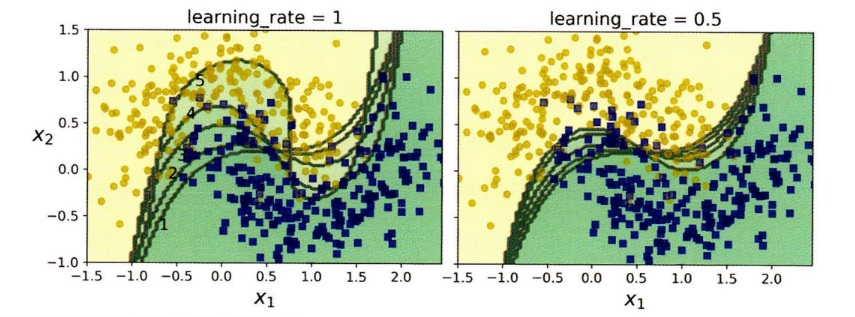
- 다음 그림은 moons 데이터셋에 훈련시킨 다섯개의 연속된 예측기의 결정 경계이다.
- 첫번째 분류기가 많은 샘플을 잘못 분류해서 이 샘플들의 가중치가 높아졌으며, 따라서 두번째 분류기는 이 샘플들을 더 정확히 예측하게 된다.
- 오른쪽 그래프는 학습률을 1에서 0.5로 반으로 낮춘 것만 빼고 똑같은 일련의 예측기를 나타낸 것이다. 즉 **잘못 분류된 샘플의 가중치는 반복마다 절반 정도만 높아진다**.
- 그림에서 볼 수 있듯이 이런 연속된 학습 기법은 경사 하강법과 비슷한 면이 있다. 
- 경사 하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가는 반면, 에이다부스트는 점차 더 좋아지도록 앙상블에 예측기를 추가한다.
- 모든 예측기가 훈련을 마치면 이 앙상블은 배깅이나 페이스팅과 비슷한 방식으로 예측을 만든다. 하지만 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용된다.

### 5. 부스팅
### 1) 에이다부스트
- 에이다부스트 알고리즘을 자세히 살펴본다.
- 각 샘플의 가중치 $w^{(i)}$는 초기에 $\frac{1}{m}$로 초기화된다. 첫번째 예측기가 학습되고, 가중치가 적용된 에러율 $r_1$이 훈련 세트에 대해 계산된다.
- 예측기의 가중치 $𝛂_j$는 학습률 하이퍼파라미터 $η$를 이용하여 $𝛂_j= ηlog\frac{1-r_j}{r_j}$로 계산한다. 예측기가 정확할수록 가중치가 더 높아진다. 만약 무작위로 예측하는 정도라면 가중치가 0에 가까울 것이고, 그보다 나쁘면 가중치는 음수가 된다. 
- 그 다음 에이다부스트 알고리즘이 가중치 업데이트 규칙을 사용하여 샘플의 가중치를 업데이트한다. 즉 잘못 분류된 샘플의 가중치가 증가된다. $w^{(i)}=
\begin{cases}
w^{(i)},\ \hat{y_j}^{(i)}={y^{(i)}} \\
w^{(i)}\exp(\alpha_j),\ \hat{y_j}^{(i)}\neq{y^{(i)}}
\end{cases}$
- 그런 다음 모든 샘플의 가중치를 정규화한다. 즉 $\displaystyle\sum_{i=1}^mw^{(i)}$으로 나눈다.
- 마지막으로 새 예측기가 업데이트된 가중치를 사용해 훈련되고 전체 과정이 반복된다. 새 예측기의 가중치가 계산되고 샘플의 가중치를 업데이트해서 또 다른 예측기를 훈련시키는 식이다.
- 이 알고리즘은 지정된 예측기 수에 도달하거나 완벽한 예측기가 만들어지면 중지된다.
- 예측을 할때 에이다부스트는 단순히 모든 예측기의 예측을 계산하고 예측기 가중치 $\alpha_j$를 더해 예측 결과를 만든다. 가중치 합이 가장 큰 클래스가 예측 결과가 된다.
$\displaystyle\hat{y(x)}=argmax\sum_{j=1}^N\alpha_j$

### 5. 부스팅
### 1) 에이다부스트
- 사이킷런은 **SAMME**라는 에이다부스트의 다중 클래스 버전을 사용한다. 클래스가 2개뿐일 때는 SAMME가 에이다부스트와 동일하다.
- 예측기가 predict_proba( ) 메서드가 있어서 클래스의 확률을 추정할 수 있다면, 사이킷런은 SAMME.R이라는 SAMME의 변종을 사용한다.
- 이 알고리즘은 예측값 대신 클래스 확률에 기반하며, 일반적으로 성능이 더 좋다.
---
- 다음 코드는 사이킷런의 AdaBoostClassifier를 사용하여 200개의 아주 얕은 결정 트리를 기반으로 하는 에이다부스트 분류기를 훈련시킨다.
- 여기에서 사용하는 결정 트리는 max_depth=1이다. 다시 말해 결정 노드 하나와 리프 노드 2개로 이루어진 트리이며, 이 트리가 AdaBoostClassifier의 기본 추정기이다.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 5. 부스팅
### 2) 그레이디언트 부스팅
- 그레이디언트 부스팅은 인기가 높은 또 하나의 부스팅 알고리즘이다.
- 그레이디언트 부스팅은 에이다부스트처럼 앙상블에 이전까지의 **오차를 보정하도록 예측기를 순차적으로 추가**한다.
-하지만 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 **이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습**시킨다.


### 5. 부스팅
### 2) 그레이디언트 부스팅
- **결정 트리를 기반 예측기로 사용**하는 간단한 회귀 문제를 해결한다.
- 이를 그레이디언트 트리 부스팅 또는 그레이디언트 부스티드 회귀 트리라고 한다.
- 먼저 **`DecisionTreeRegressor`**를 잡음이 섞인 2차 곡선 형태의 훈련 세트에 학습시킨다.
- 그 다음 첫번째 예측기에서 생긴 잔여 오차에 두번째 `DecisionTreeRegressor`를 훈련시킨다.
- 다음으로 두번째 예측기가 만든 잔여 오차에 세번째 회귀 모델을 훈련시킨다.
- 3개의 트리를 포함하는 앙상블 모델이 생겼다. 새로운 샘플에 대한 예측을 만드려면 모든 트리의 예측을 더한다.
- 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아진다.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [ ]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [ ]:
y3 = y - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [ ]:
y_pred = sum(tree.predict(X_test) for tree in (tree_reg1, tree_reg2, tree_reg3))

### 5. 부스팅
### 2) 그레이디언트 부스팅
- 사이킷런의 **`GradientBoostingRegressor`**를 사용하면 **GBRT 앙상블**을 간단하게 훈련시킬 수 있다. 
- 트리 수(n_estimators)와 같이 앙상블의 훈련을 제어하는 매개변수는 물론, `RandomForestRegressor`와 아주 비슷하게 결정 트리의 성장을 제어하는 매개변수(max_depth, min_samples_leaf)를 가지고 있다.
- 다음 코드는 이전의 앙상블과 같은 앙상블을 만드는 코드이다.
- **`learning_rate`** 매개변수가 **각 트리의 기여 정도를 조절**한다. 
- 이를 0.1처럼 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만, 일반적으로 예측의 성능은 좋아진다. 이런 방법을 **축소** 규제 방법이라고 한다.
---
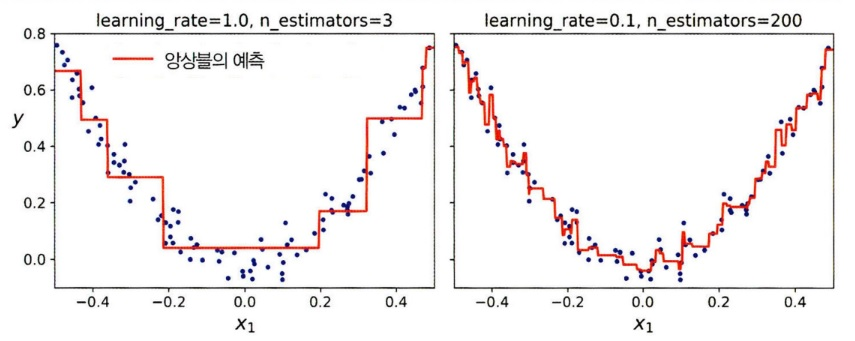
- 다음 그림은 작은 학습률로 훈련시킨 2개의 GBRT 앙상블을 보여준다.
- 왼쪽은 훈련 세트를 학습하기에는 트리가 충분하지 않은 반면, 오른쪽은 트리가 너무 많아 훈련 세트에 과대적합되었다.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

### 5. 부스팅
### 2) 그레이디언트 부스팅
- **최적의 트리 수**를 찾기 위해서는 **조기 종료 기법**을 사용할 수 있다.
- 간단하게 **`staged_predict( )`** 메서드를 사용한다. 이 메서드는 훈련의 각 단계(트리 하나, 트리 둘 등)에서 앙상블에 의해 만들어진 **예측기를 순회하는 반복자**(iterator)를 반환한다.
---
- 다음 코드는 120개의 트리로 GBRT 앙상블을 훈련시키고 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증 오차를 측정한다.
- 마지막에 최적의 트리 수를 사용하여 새로운 GBRT 앙상블을 훈련시킨다.
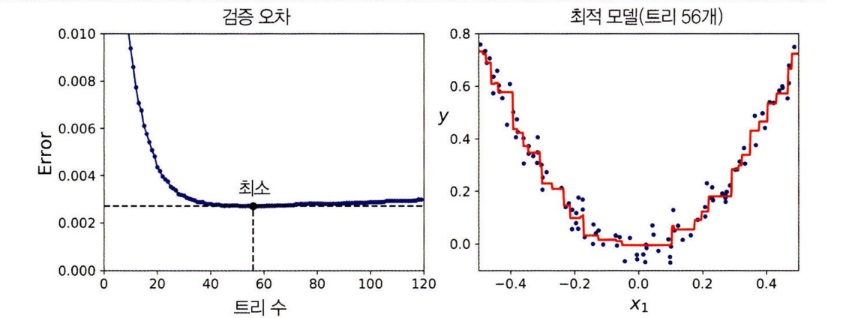
- 그림의 왼쪽은 검증 오차이고, 오른쪽은 최적 모델의 예측이다.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=64)

### 5. 부스팅
### 2) 그레이디언트 부스팅
- 많은 수의 트리를 먼저 훈련시키고 최적의 수를 찾기 위해 살펴보는 대신 실제로 훈련을 중지하는 방법으로 조기 종료를 구현할 수도 있다.
- **`warm_start=True`**로 설정하면 사이킷런이 `fit( )` 메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 한다.
- 다음 코드는 연속해서 다섯번의 반복 동안 검증 오차가 향상되지 않으면 훈련을 멈춘다.
--- 
- `GradientBoostingRegressor`는 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있는 **subsample** 매개변수를 지원한다.
- 예를 들어 subsample=0.25라고 하면, 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습된다.
- 그러면 편향이 높아지는 대신 분산이 낮아지게 되며, 훈련 속도를 상당히 높인다.
- 이런 기법을 **확률적 그레이디언트 부스팅**(stochastic gradient boosting)이라고 한다.

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)

    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

### 5. 부스팅
### 2) 그레이디언트 부스팅
- 최적화된 그레이디언트 부스팅 구현으로 **`XGBoost`** 파이썬 라이브러리가 유명하다.
- **XGBoost**는 익스트림 그레이디언트 부스팅(extreme gradient boosting)의 약자이다.
- XGBoost는 머신러닝 경연 대회에서 우승 후보들이 사용하는 중요 도구 중 하나이다. 
- XGBoost API는 사이킷런과 매우 비슷하며, 자동 조기 종료와 같은 여러가지 좋은 기능을 제공한다.

In [ ]:
import xgboost
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [ ]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

### 6. 스태킹
- 마지막 앙상블 모델은 **스태킹**이다.
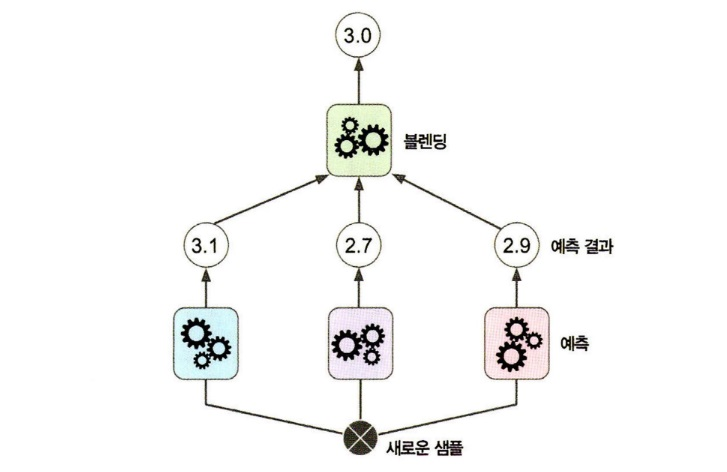
- 다음 그림의 세 예측기는 각각 다른 값을 예측하고 마지막 예측기(**블렌더** 또는 **메타 학습기**)가 이 예측을 입력받아 최종 예측을 만든다.
- **블렌더를 학습**시키는 일반적인 방법은 **홀드 아웃 세트를 사용**하는 것이다.
- 먼저 훈련 세트를 2개의 서브셋으로 나눈다. 첫번째 서브셋은 첫번째 레이어의 예측을 훈련시키기 위해 사용된다.
- 그 다음 첫번째 레이어의 예측기를 사용하여 두번째 세트에 대한 예측을 만든다. 예측기들이 훈련하는 동안 이 샘플들을 전혀 보지 못했기 때문에 이때 만들어진 예측은 완전히 새로운 것이다.
- 홀드 아웃 세트의 각 샘플에 대해 3개의 예측값이 있다. 타겟값은 그대로 쓰고 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 만들 수 있다.
- 블렌더가 새 훈련 세트로 훈련된다. 즉 첫번째 레이어의 예측을 가지고 타겟값을 예측하도록 학습된다.
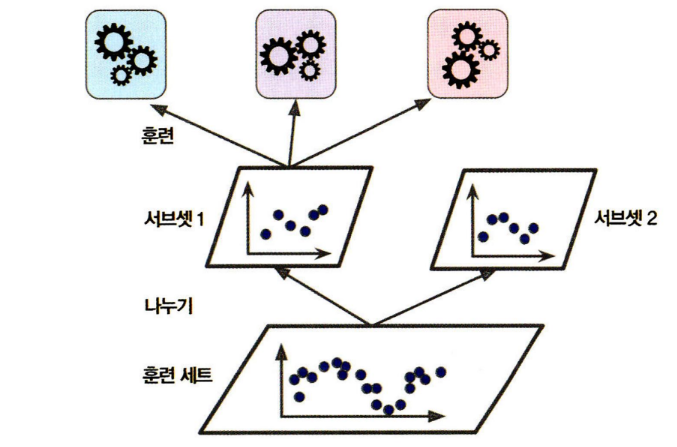

### 6. 스태킹
- 사실 이런 방식의 블렌더를 여러 개 훈련시키는 것도 가능하다. 예를 들어 하나는 선형 회귀로, 다른 하나는 랜덤 포레스트 회귀로 하는 것이다.
- 그러면 블렌더만의 레이어가 만들어진다. 이렇게 하려면 훈련 세트를 세개의 서브셋으로 나눈다.
- 첫번째 세트는 첫번째 레이어를 훈련시키는데 사용되고, 두번째 세트는 첫번째 레이어의 예측기로 두번째 레이어를 훈련시키기 위한 훈련 세트를 만드는데 사용된다. 세번째 세트는 세번째 레이어를 훈련시키기 위한 훈련 세트를 만드는데 사용된다.
- 각 레이어를 차례대로 실행해서 새로운 샘플에 대한 예측을 만들 수 있다.
- 사이킷런은 스태킹을 직접 지원하지 않으므로 코드를 이용하여 직접 구현해야 한다.